# drifting context branch

In [2]:
import numpy as np
import tensorflow as tf

from pureEM import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


- next: not sure why but nback discounting with 0.9 discount rate that performs best. if I set discount rate to 0, which should just return the nback context, the network doesn't learn. I thought that would have been a strictly easier task 
    - setting the discount factor to 0 means the network is always retrieving the nback context; which bears no information about what stimulus occured in that context. 
- potential next steps:
    - have retrieval weights be produced by the network instead of automatically computed - but in some way it already is produced by the network, insofar as the network is finding embeddings for context and stim that allow it to perform the computations. 
    - sweep param space and look into the memory represnetations that the network develops (e.g. how does retrieval vector change as a function of environment params?)

In [78]:

def train_loop(nstim,ntrials,epochs=10000):
  net = PureEM(nstim=nstim,ntrials=ntrials)
  task = NBackTask(nstim=nstim)

  L = -1*np.ones(epochs)
  A = -1*np.ones(epochs)
  for ep in range(epochs): 
    T,X,Y = task.genseq(ntrials=ntrials)
    feed_dict = {net.trial_ph:T,net.stim_ph:X,net.y_ph:Y}
    ops = [
      net.minimizer,
      net.train_loss,
      net.response,
      net.retrieved_memory
          ]
    outs = net.sess.run(ops,feed_dict)
    _,loss,yhat,m_T = outs

    L[ep] = loss.mean()
    A[ep] = np.mean(yhat==Y[:,2:])
  return L,A


In [79]:
nstim,ntrials = 5,10
epochs = 20000
L,A = train_loop(nstim,ntrials,epochs)

Tensor("strided_slice_2:0", shape=(1, 25), dtype=float32)
Tensor("strided_slice:0", shape=(2, 25), dtype=float32)
[0.9, 1.0]
Tensor("strided_slice_4:0", shape=(1, 25), dtype=float32)
Tensor("M_keys_write:0", shape=(3, 25), dtype=float32)
[0.81, 0.9, 1.0]
Tensor("strided_slice_6:0", shape=(1, 25), dtype=float32)
Tensor("M_keys_write_1:0", shape=(4, 25), dtype=float32)
[0.7290000000000001, 0.81, 0.9, 1.0]
Tensor("strided_slice_8:0", shape=(1, 25), dtype=float32)
Tensor("M_keys_write_2:0", shape=(5, 25), dtype=float32)
[0.6561, 0.7290000000000001, 0.81, 0.9, 1.0]
Tensor("strided_slice_10:0", shape=(1, 25), dtype=float32)
Tensor("M_keys_write_3:0", shape=(6, 25), dtype=float32)
[0.5904900000000001, 0.6561, 0.7290000000000001, 0.81, 0.9, 1.0]
Tensor("strided_slice_12:0", shape=(1, 25), dtype=float32)
Tensor("M_keys_write_4:0", shape=(7, 25), dtype=float32)
[0.531441, 0.5904900000000001, 0.6561, 0.7290000000000001, 0.81, 0.9, 1.0]
Tensor("strided_slice_14:0", shape=(1, 25), dtype=float32)
Te

Text(0,0.5,'accoracy')

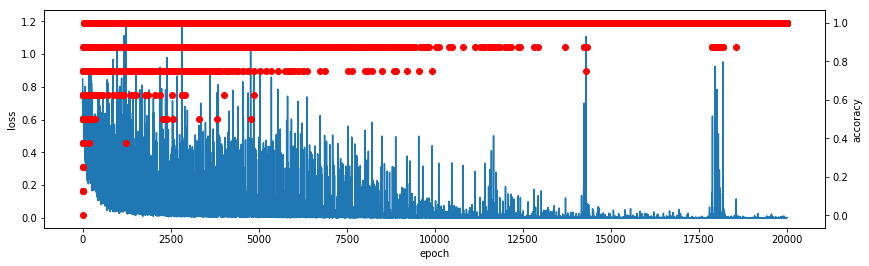

In [80]:
plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(L)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax2 = ax.twinx()
ax2.scatter(range(len(A)),A,c='r')
ax2.set_ylabel('accoracy')
# plt.savefig('figures/pureem/train_lossacc')

### debugging

In [679]:
ntrials=5
net = PureEM(ntrials=ntrials,dim=2)
# task = NBackTask()
# net.reinitialize()
ntrials=5
for ep in range(1): 
  T,X,Y = task.genseq(ntrials=ntrials)
  feed_dict = {net.trial_ph:T,net.stim_ph:X,net.y_ph:Y}
  ops = [
    net.M_keys,
    net.query_key_sim,
    net.stim,
    net.retrieved_memory,
    net.M_values,
    net.context,
    net.response_in
  ]
  outs = net.sess.run(ops,feed_dict)

Tensor("strided_slice_2:0", shape=(1, 2), dtype=float32)
Tensor("strided_slice:0", shape=(2, 2), dtype=float32)
[1.0, 0.9]
Tensor("strided_slice_4:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write:0", shape=(3, 2), dtype=float32)
[0.9, 1.0, 0.9]
Tensor("strided_slice_6:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write_1:0", shape=(4, 2), dtype=float32)
[0.81, 0.9, 1.0, 0.9]


In [680]:
# stim seq
for x in X.squeeze():
  print(x)

1
2
0
2
2


In [681]:
print('cos')
print(outs[1].round(3))
# s_t

# sim

print('M_K')
print(outs[0])
print('stim_T')
print(outs[2][:,-1])
print('M_V')
print(outs[4])
print('m_T')
print(outs[3])
print('c_T')
print(outs[5][:,-1])
print('x_in')
print(outs[6].reshape(2,-1))

cos
[0.004 0.4   0.196 0.4  ]
M_K
[[ 0.11894773  0.9486887 ]
 [-0.27373168 -0.96113366]
 [-0.6422192   0.66132146]
 [-0.27373168 -0.96113366]
 [-0.27373168 -0.96113366]]
stim_T
[[-0.27373168 -0.96113366]]
M_V
[[ 0.5238827  -0.00179951]
 [-0.33924514  0.18750945]
 [-0.89836234 -0.76285404]
 [-0.7214177  -0.03025485]
 [-0.0098532   0.42147025]]
m_T
[[-0.59812367 -0.08630171]]
c_T
[[-0.0098532   0.42147025]]
x_in
[[-0.0098532   0.42147025]
 [-0.59812367 -0.08630171]]


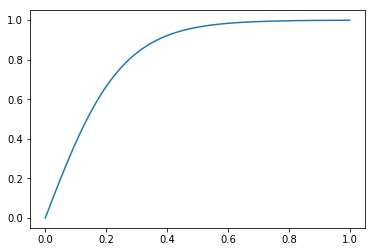

In [592]:
x = np.linspace(0,1,100)
t=4
y=np.tanh(t*x)
plt.plot(x,y)